<a href="https://colab.research.google.com/github/Sujangyawali/smart_traffic_management_system/blob/main/Emergency_vehicle_detection_using_mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras==2.1.0 
!pip install tensorflow==1.15.0

     |████████████████████████████████| 307kB 15.3MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 50.0MB/s 
     |████████████████████████████████| 512kB 58.0MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=de691bd340c647a7217797beaac08eee3d46ddcdc75f2bb1bb51f0970daa3677
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0

In [ ]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
from imgaug import augmenters as iaa

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.89 MiB/s, done.
Resolving deltas: 100% (561/561), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrc

In [ ]:
#part of localization
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [ ]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

class KangarooDataset(Dataset):
  def load_dataset(self,dataset_dir,is_train=True):
    self.add_class("dataset",1,"firetruck")
    self.add_class("dataset",2,"ambulance")
    self.add_class("dataset",3,"hiace")
    self.add_class("dataset",4,"bus")
    self.add_class("dataset",5,"truck")
    self.add_class("dataset",6,"car")
    self.add_class("dataset",7,"jeep")
    self.add_class("dataset",8,"bike")


    images_dir=dataset_dir + '/image/'
    annotations_dir=dataset_dir +'/annotation/'

    a=0
    for filename in listdir(images_dir):
      a=a+1
      image_id=filename[:-4]
      if image_id in ['vid26.mp4frame195','cars_mage_only28','9k_ (20)']:
        continue
				
      if is_train and a <28:
        continue
      if not is_train and a>28:
        continue
      img_path=images_dir + filename
      ann_path=annotations_dir+image_id+'.xml'

      self.add_image('dataset',image_id=image_id,path=img_path,annotation=ann_path)

  def extract_boxes(self, filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each object
    boxes = list()
    for object in root.findall('.//object'):
        box_class_list = list()
        #find bbox coordinates
        for box in object.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            box_class_list.append(coors)
        #get the name of the object class corresponding to the bbox
        for name in object.findall('.//name'):
            box_class_list.append(name.text)
        #append the box coors and respective name to a list
        boxes.append(box_class_list)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height



  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location, here the annotation dir in project dir
    path = info['annotation']
    # load XML
    boxes, w, h = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
        box = boxes[i][0]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index(boxes[i][1]))

    return masks, asarray(class_ids, dtype='int32') 


    def image_reference(self,image_id):
      info=self.image_info[image_id]
      return info['path']


# train set
train_set = KangarooDataset()
train_set.load_dataset('/content/drive/MyDrive/8_class', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))


# test/val set
test_set = KangarooDataset()
test_set.load_dataset('/content/drive/MyDrive/8_class', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 557
Test: 27


In [ ]:
from mrcnn.config import Config
# define a configuration for the model
class FiretruckConfig(Config):
	# Give the configuration a recognizable name
	NAME = "eight_class_cfgh"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 8
	#GPU_COUNT=1
	# Number of training steps per epoch
	STEPS_PER_EPOCH=250
	BATCH_SIZE=4
	DETECTION_MAX_INSTANCES =10
	IMAGES_PER_GPU=4

# prepare config
config = FiretruckConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [ ]:
import mrcnn.model as modellib
# define the model
model = modellib.MaskRCNN(mode='training', model_dir='./', config=config)

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
    #downloading weight into the current directory

In [ ]:
# load weights (mscoco)
model.load_weights('/content/Mask_RCNN/eight_class_cfgh20210210T0241/mask_rcnn_eight_class_cfgh_0020.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 20


In [ ]:
# train weights (output layers or 'heads')
history=model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='all')
new_history = model.keras_model.history.history


Starting at epoch 20. LR=0.001

Checkpoint Path: ./eight_class_cfgh20210210T0241/mask_rcnn_eight_class_cfgh_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

In [ ]:
epochs = range(1, len(new_history['loss'])+1)
pd.DataFrame(new_history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.087884,0.003078,0.198025,0.258729,0.333299,0.294746,1.283269,0.006057,0.281550,0.145090,0.429673,0.420891
2,0.914110,0.001264,0.193708,0.174059,0.305203,0.239868,0.877371,0.005210,0.250404,0.112110,0.231961,0.277677
3,0.758778,0.001493,0.176272,0.144904,0.207413,0.228689,0.657160,0.002304,0.154633,0.085046,0.175032,0.240137
4,0.710624,0.001719,0.130638,0.128321,0.207385,0.242553,0.588128,0.002007,0.138591,0.075976,0.146046,0.225501
5,0.803057,0.004070,0.309186,0.107310,0.152514,0.229970,0.529788,0.002068,0.128384,0.066255,0.125523,0.207550
6,0.726936,0.002100,0.172042,0.134065,0.188362,0.230358,0.440578,0.001539,0.100652,0.054121,0.098742,0.185518
7,0.755230,0.003165,0.261987,0.109999,0.155327,0.224745,0.407892,0.001442,0.092556,0.054614,0.087713,0.171558
8,0.730860,0.002650,0.228480,0.086559,0.159637,0.253527,0.369940,0.001288,0.081961,0.047702,0.075404,0.163578
9,0.691415,0.003102,0.199033,0.087536,0.176922,0.224816,0.358885,0.001456,0.080723,0.043714,0.072259,0.160726
10,0.628099,0.002265,0.192832,0.082504,0.130237,0.220254,0.301660,0.001145,0.061327,0.035928,0.056935,0.146317


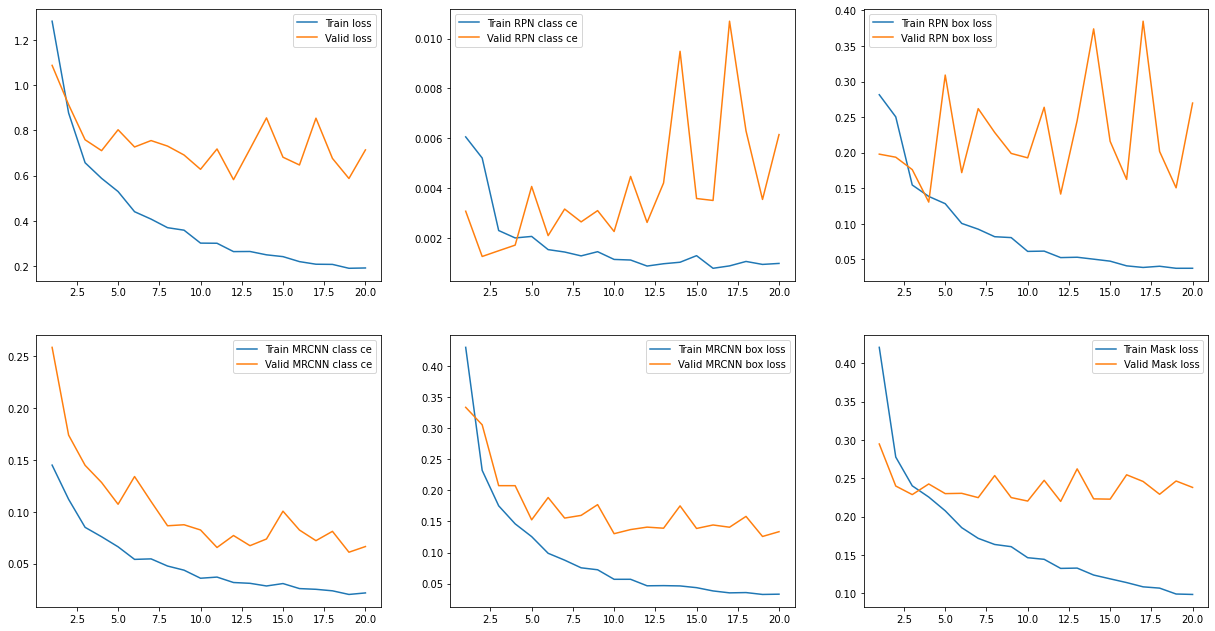

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, new_history["loss"], label="Train loss")
plt.plot(epochs, new_history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, new_history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, new_history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)

plt.plot(epochs, new_history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, new_history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, new_history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, new_history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, new_history["mrcnn_bbox_loss"], label="Train MRCNN box loss")

plt.plot(epochs, new_history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, new_history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, new_history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(new_history["val_loss"])
print("Best Epoch:", best_epoch + 1, new_history["val_loss"][best_epoch])

Best Epoch: 12 0.5822643685340881
